## Download and Import required libraries

In [1]:
!pip install -q torch
!pip install -q opencv-python
!pip install -q numpy
!pip install -q matplotlib

In [ ]:
# import os

# for filename in range(0,len(os.listdir("/home/drajani/Downloads/UNET/ConvLSTM/TESTING/forceps/")),1):
#     print(f"/home/drajani/Downloads/UNET/ConvLSTM/TESTING/forceps/{filename}.png")

#     os.rename(f"/home/drajani/Downloads/UNET/ConvLSTM/TESTING/forceps/{filename}.png", f"/home/drajani/Downloads/UNET/ConvLSTM/TESTING/dest/{filename+10}.png")




#     # my_dest = str(i) + ".png"
#     # my_source =path + filename
#     # # my_dest =path +  my_dest
#     # # rename() function will
#     # # rename all the files
#     # os.rename(my_source,'/home/drajani/Downloads/UNET/ConvLSTM/TESTING/new_forceps/'+my_dest)
#     # i += 1


In [4]:
# torch dependencies
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# general dependencies
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import io
import imageio
from ipywidgets import widgets, HBox, VBox
import os, shutil
from PIL import Image, ImageFilter
from skimage.measure import find_contours
from IPython.display import display, Image
from moviepy.editor import *
from natsort import natsorted
import glob

# within repository dependencies
from Seq2Seq import Seq2Seq
from utils import *
from ConvLSTM import ConvLSTM
from ConvLSTMCell import ConvLSTMCell

# checking for GPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##  Video dataset preparation

In [ ]:
# Define numpy file generated from laser scans
npy_filename = '/home/drajani/Downloads/UNET/ConvLSTM/Data/all_npy_files/shapes1-shapes2-1mm-ascans.npy'

# Define rgb image directory to store rgb images
rgb_image_dir = "/home/drajani/Downloads/UNET/ConvLSTM/Data/shapes_1_2/shapes_1_2_convlstm/"

# Define video address (incl. video file name) where the produced video from rgb images needs to be stored
video_address= "/home/drajani/Downloads/UNET/ConvLSTM/Data/shapes_1_2/shapes_1_2_videos_convlstm/shapes_1_2_video.mp4"



# convert npy to rgb images
npy_to_images(npy_filename= npy_filename, rgb_image_dir= rgb_image_dir)

# convert rgb images to video
img_to_video (rgb_image_dir= rgb_image_dir, video_address= video_address)

In [ ]:
# Define the video repository path
video_repo = '/home/drajani/Downloads/UNET/ConvLSTM/Data/shapes_1_2/shapes_1_2_videos_convlstm/'
input_video_path = video_address

# List of augmentations and their arguments
augmentations = [
    (frame_skipping, {'skip_factor': 2}),
    (reverse_video, {}),
    (random_flip, {'flip_code':-1}),
    (random_flip, {'flip_code':1})
]

combined_video_path = apply_augmentations_and_combine(input_video_path, video_repo, augmentations)

In [ ]:
# Define the repository path where the combined final augmented video can be saved as rgb images
dir_video_to_img='/home/drajani/Downloads/UNET/ConvLSTM/Data/shapes_1_2/shapes_1_2_convlstm/'

# splitting video to images sequentially
splitter(combined_video_path= combined_video_path,  dir_video_to_img= dir_video_to_img)

In [ ]:
# Define the repository path where rgb images when converted to grayscale images can be saved
# dir_img_to_grayscale='/home/drajani/Downloads/UNET/ConvLSTM/Data/shapes_1_2/gray_images_shapes_1_2_convlstm/'


# convert RGB images to grayscale
convert_to_grayscale(dir_video_to_img= '/home/drajani/Downloads/UNET/ConvLSTM/TESTING/shapes2',  dir_img_to_grayscale= '/home/drajani/Downloads/UNET/ConvLSTM/TESTING/shapes2_gray')

In [5]:
# Dataset generation
dir_img_to_grayscale = '/home/drajani/Downloads/UNET/ConvLSTM/Data/shapes/gray_images_shapes_convlstm'
batches = 120
length_of_sequence = 20
img_size = (128,128)

# batches * length_of_sequence = len(dir_img_to_grayscale)
print('Length of directory containing grayscale images: ', len(os.listdir(dir_img_to_grayscale)))

input_data = create_dataset(dir_img_to_grayscale=dir_img_to_grayscale, batches=batches, length_of_sequence=length_of_sequence, img_size=img_size , shuffling=False)
print("Overall input data shape: ", input_data.shape) # in the form of a numpy array

Length of directory containing grayscale images:  2400
Overall input data shape:  (120, 20, 128, 128)


In [6]:
testing = input_data
print(testing.shape)

(120, 20, 128, 128)


## Train/Validation/Test split & DataLoading

In [7]:
# sanity check loaded dataset (press any key on keyborad to exit, dont press close window on the opencv window, program hangs up due to that)
cv2.imshow(' ',input_data[-1][-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
# Dataset split into training, validation and testing data
training = input_data[:100]
validation = input_data[100:110]
testing = input_data[110:120]

# Loading data for training and validation respectively
Dataload_training = DataLoader(training, batch_size=2, collate_fn=custom, shuffle=True,drop_last=True)
Dataload_validation = DataLoader(validation, batch_size=2, collate_fn=custom, shuffle=True,drop_last=True)


print("Train data shape: ",training.shape)
print("Validation data shape: ",validation.shape)
print("Testing data shape: ",testing.shape)

Train data shape:  (100, 20, 128, 128)
Validation data shape:  (10, 20, 128, 128)
Testing data shape:  (10, 20, 128, 128)


## Sequential Data Visualization

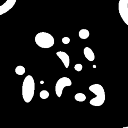

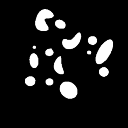

In [11]:
# fetching a batch of input data
five_dim_input, four_dim_input, _, _ = next(iter(Dataload_training))

# redoing the scaling done in the custom collate function so that the pixel values are back in the range [0, 255]
five_dim_input = five_dim_input.cpu().numpy() * 255.0
five_dim_input = five_dim_input.squeeze(1)


for video in five_dim_input[:5]:  # Select how many batches to visualize the data upon
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",duration = 200,loop=0)
        display(Image(data=gif.getvalue(), format='png'))



## Instantiate Model, Optimizer and Loss

In [8]:
def contour_center_loss(output, temp_dir):

        plt.axis('off')
        plt.imshow(output, cmap='gray', interpolation='bicubic')
        plt.savefig(os.path.join(temp_dir,'frame_TRAIN.png'), bbox_inches='tight', pad_inches=0)
        plt.close()


        logo = os.path.join(temp_dir,'frame_TRAIN.png')
        Image.open
        with Image.open(logo) as stamp_img:
            stamp_img.load()

        # next 4 code lines reference: https://realpython.com/image-processing-with-the-python-pillow-library/#creation-of-a-watermark
        stamp_img = stamp_img.convert("L") # This line converts the image to grayscale mode
        stamp_img = stamp_img.point(lambda x: 255 if x > 10 else 0)
                            # applies a point operation on the grayscale image. The lambda function sets the pixel value = 255 (white),
                            # if the pixel value > threshold, otherwise, pixel = 0 (black), basically creates a binary image.

        stamp_img = stamp_img.resize((stamp_img.width, stamp_img.height))
        stamp_img = stamp_img.filter(ImageFilter.CONTOUR) # The ImageFilter.CONTOUR filter is used to highlight the edges and contours of objects in the image.

        # Convert the filtered image to a NumPy array
        img_array = np.array(stamp_img)

        # Find the contours using skimage.measure.find_contours
        contours = find_contours(img_array, 0.5)

        # Calculate the areas of the contours
        contour_areas = [len(contour) for contour in contours]

        # Sort the contours based on area (largest to smallest)
        sorted_contours = [contour for _, contour in sorted(zip(contour_areas, contours), key=lambda x: x[0], reverse=True)]

        # Keep only the contours after removing the largest and second largest
        filtered_contours = sorted_contours[2:]

        centers = []  # list of object centroids in a frame

        for contour in filtered_contours:

            # Calculate the center of the contour
            center = np.mean(contour, axis=0)
            center[0] = int(center[0])
            center[1] = int(center[1])

            intermed = np.array([[center[0]], [center[1]]])
            centers.append(intermed)


        empty_the_repo(temp_dir)


        return centers


In [12]:
rnn_model = Seq2Seq(input_size=(2,1,10,128,128),units=(2,1,128,128))
# readout, hx = rnn_model(input=torch.rand(2,1,10,128,128))#, hx=torch.rand(2,1,128,128))
rnn_model = rnn_model.to('cuda')

optimizer = Adam(rnn_model.parameters(), lr=1e-4)

loss_BCE = nn.BCELoss(reduction='sum')

# MSE loss for centerloss calculation
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()

    def forward(self, predicted_value, target_value):
        predicted_tensor = torch.tensor(predicted_value, dtype=torch.float32)
        target_tensor = torch.tensor(target_value, dtype=torch.float32)
        mse_loss = nn.MSELoss()   # L2 norm loss (PyTorch souce doc. for mathematical formulation: https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)
        loss = mse_loss(predicted_tensor, target_tensor)
        return loss

loss_function = CustomMSELoss()


In [ ]:
# # input frames of video are already gray scale images hence the desired_channels = 1
# model = Seq2Seq(num_channels=1, num_kernels=64, kernel_size=(3,3), padding=(1,1), activation="relu", frame_size=(128,128), num_layers=3).to(device)

# optimizer = Adam(model.parameters(), lr=1e-4)

# # Binary Cross Entropy (BCE), pixel values between 0 and 1 (PyTorch souce doc. for mathematical formulation: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
# loss_BCE = nn.BCELoss(reduction='sum')

# # MSE loss for centerloss calculation
# class CustomMSELoss(nn.Module):
#     def __init__(self):
#         super(CustomMSELoss, self).__init__()

#     def forward(self, predicted_value, target_value):
#         predicted_tensor = torch.tensor(predicted_value, dtype=torch.float32)
#         target_tensor = torch.tensor(target_value, dtype=torch.float32)
#         mse_loss = nn.MSELoss()   # L2 norm loss (PyTorch souce doc. for mathematical formulation: https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)
#         loss = mse_loss(predicted_tensor, target_tensor)
#         return loss

# loss_function = CustomMSELoss()





## Training

In [ ]:
loss_mse = nn.MSELoss() 


for batch_num, (input, target,_,_) in enumerate(Dataload_training, 1):
    print(batch_num)
    print(input.shape)
    
    output = rnn_model(input)
    output = output[:,:,-1]

    print(output.shape)
    print(target.shape)

    print(output.max())
    print(output.min())
    print('--------------------')
    print(target.min())
    print(target.max())



    loss2 = loss_BCE(output.flatten(), target.flatten())
    loss2 = loss_mse(output, target)
    loss =  loss2

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    print(loss)

# b,c,sl,h,w
# b,c,h,w


### Without Centerloss

In [ ]:
# WITHOUT CENTERLOSS
centerloss_flag = False
epochs = 100

# for collecting training and validation loss history
train_loss_list = []
val_loss_list = []

for epoch in range(1, epochs + 1, 1):

    overall_training_loss = 0
    rnn_model.train()
    for batch_num, (input, target,_,_) in enumerate(Dataload_training, 1):
        output = rnn_model(input)

        output = output[:,:,-1]




        output1 = output[0].permute(1,2,0)
        cv2.imwrite(f'/home/drajani/Downloads/UNET/ConvLSTM/temp_dir/image_{epoch}.png',output1.detach().cpu().numpy())


        loss = loss_BCE(output.flatten(), target.flatten())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        overall_training_loss = overall_training_loss  + loss.item()
    overall_training_loss = overall_training_loss / len(Dataload_training.dataset)
    train_loss_list.append(overall_training_loss)



    overall_validation_loss = 0
    rnn_model.eval()
    with torch.no_grad():
        for input, target,_,_ in Dataload_validation:
            output = rnn_model(input)

            output = output[:,:,-1]


            
            loss = loss_BCE(output.flatten(), target.flatten())


            overall_validation_loss = overall_validation_loss + loss.item()
    overall_validation_loss = overall_validation_loss / len(Dataload_validation.dataset)
    val_loss_list.append(overall_validation_loss)


    print("Epoch no.: {} Overall Training Loss: {:.2f} and Overall Validation Loss: {:.2f}\n".format(epoch, overall_training_loss, overall_validation_loss))

### With Centerloss

In [ ]:
# WITH CENTERLOSS
centerloss_flag = True
epochs = 4


val_loss_list = []
train_loss_list = []


for epoch in range(1, epochs+1):

    train_loss = 0
    model.train()
    for batch_num, (input, target,_,_) in enumerate(Dataload_training, 1):

        output = model(input)

        batch_size = output.size(0)
        loss_global = []
        for i in range(batch_size):
            cens_op = contour_center_loss(np.array(output[i][0].reshape(128,128,1).cpu().detach()),
                                          temp_dir = '/home/drajani/Downloads/UNET/ConvLSTM/temp_dir/')
            cens_tgt = contour_center_loss(np.array(target[i][0].reshape(128,128,1).cpu().detach()),
                                           temp_dir = '/home/drajani/Downloads/UNET/ConvLSTM/temp_dir/')
            loss_ = 0
            for op, tgt in zip(cens_op, cens_tgt):
                predicted_tensor = torch.tensor(op, dtype=torch.float32)
                target_tensor = torch.tensor(tgt, dtype=torch.float32)

                loss_ += loss_function.forward(predicted_tensor, target_tensor)
            try:
                loss_ /= len(cens_op)  # Calculate average loss
            except ZeroDivisionError:
                continue

            loss_global.append(loss_)


        loss = loss_BCE(output.flatten(), target.flatten())  +  sum(loss_global)
        # print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(Dataload_training.dataset)




    val_loss = 0
    model.eval()
    with torch.no_grad():
        for input, target in Dataload_validation:
            output = model(input)

            batch_size = output.size(0)
            loss_global = []
            for i in range(batch_size):
                cens_op = contour_center_loss(np.array(output[i][0].reshape(128,128,1).cpu().detach()))
                cens_tgt = contour_center_loss(np.array(target[i][0].reshape(128,128,1).cpu().detach()))
                loss_ = 0
                for op, tgt in zip(cens_op, cens_tgt):
                    predicted_tensor = torch.tensor(op, dtype=torch.float32)
                    target_tensor = torch.tensor(tgt, dtype=torch.float32)

                    loss_ += loss_function.forward(predicted_tensor, target_tensor)
                try:
                    loss_ /= len(cens_op)  # Calculate average loss
                except ZeroDivisionError:
                    continue

                loss_global.append(loss_)

            loss = loss_BCE(output.flatten(), target.flatten())  +  sum(loss_global)
            val_loss += loss.item()
    val_loss /= len(Dataload_validation.dataset)


    print("Epoch no.: {} Overall Training Loss: {:.2f} and Overall Validation Loss: {:.2f}\n".format(epoch, train_loss, val_loss))


    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)

### Loss history plot

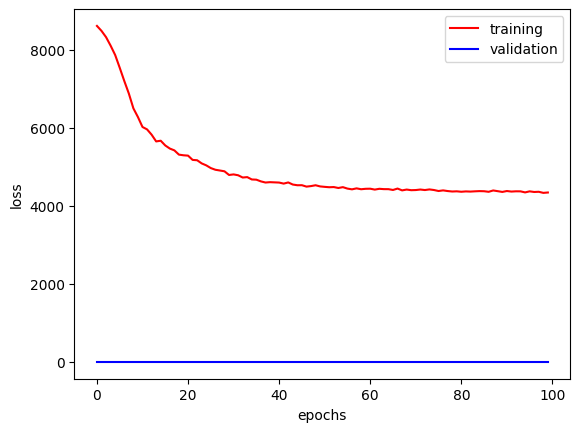

In [10]:
plot(train_loss_list, 'training', val_loss_list, 'validation', 'epochs', 'loss')

### Save model weights

In [ ]:
# Define model weight save path
weight_path = '/home/drajani/Downloads/UNET/ConvLSTM/weights/test.pt'

# Save model weights
torch.save(model.state_dict(), weight_path)

### Load saved model weights

In [ ]:
# model = Sequence_to_Sequence(desired_channels=1, kernels=64, kernel_size=(3,3), padding=(1,1), activation="relu", frame_size=(128,128), LAYERS=3).to(device)


In [ ]:
# load saved model
weight_path = '/home/drajani/Downloads/UNET/ConvLSTM/weights/weights_20_epochs_shapes_training_centerloss.pt'
model = Seq2Seq(num_channels=1, num_kernels=64, kernel_size=(3,3), padding=(1,1), activation="relu", frame_size=(128,128), num_layers=3).to(device)

# model = Sequence_to_Sequence(desired_channels=1, kernels=64, kernel_size=(3,3), padding=(1,1), activation="relu", frame_size=(128,128), LAYERS=3).to(device)
model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

## Inference

In [ ]:
"""
Example to show how prediction_generation() function works:

no. of batches of testing data = 2
test_batch_shape  = (2, 1, 20, 128, 128) = 5d tensor --> {input batches fetched from testing data}
target_shape = (2, 10, 128, 128)    = 4d tensor
lets take first batch of testing data, shape is = (1,1,20,128,128)
here we take first 10 frames as input, hence input_shape = (1, 1, 10, 128, 128)
then we take 10 frame and predict the 11th frame and then keep on shifting this
until the end of the sequence length.(for every frame we take preceding 10 frames for input)

Now if we do this for both batches i.e. no. of batches = 2, therefore we get,
# test_batch_shape  = (2, 1, 20, 128, 128) (given)
# target_shape = (2, 10, 128, 128)
# input_shape  = (2, 1, 10, 128, 128)
# output_shape  = (2, 10, 128, 128)

Hence, output_shape has convlstm predictions & target_shape has ground truth.

"""


def prediction_generation (Dataload_testing):

    # Fetch a batch of testing data from test dataloader
    _, _, test_batch, target = next(iter(Dataload_testing))
    print('batch_shape: ', test_batch.shape) # (2, 1, 20, 128, 128)
    print('taget_shape: ', target.shape)     # (2, 10, 128, 128)

    # out of 20 frames in sequence we intend to predict the last 10 frames,
    # hence last 10 frames are target frams
    # target = np.array(test_batch.squeeze(1).to('cpu'))[:,10:]

    # Initialize output as a sequence of zeros
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    lisk = []

    for t in range(0,len(target[0]),1):
        input = test_batch[:,:,t:t+10]
        print('Input_shape: ', input.shape)    # (2, 1, 10, 128, 128)

        output[:,t]=(model(input).squeeze(1).cpu()>0.5)*255.0
        print('Output_shape: ', output.shape)  # (2, 10, 128, 128)

        lisk.append(test_batch[:,:,len(input[0][0])])
        
        print('-------------------------------------------')

    return target, output, lisk


In [ ]:
# k = torch.rand(2, 10, 128, 128)
# len(k[0])

### (for testing on the same dataset model is trained upon)
E.g., shapes_1_2

In [ ]:
## Get predictions and ground truth comparisons
# note: here using the testing dataset generated in "Train/Validation/Test split & DataLoading" section
Dataload_testing = DataLoader(testing, batch_size=testing.shape[0] + 1, collate_fn= custom, shuffle=False) # specific to each dataset to test
target_, output_, lisk = prediction_generation(Dataload_testing= Dataload_testing)

# sanity check of predictions
cv2.imshow(' ',output_[-1][6])
cv2.waitKey(0)
cv2.destroyAllWindows()

batch_shape:  torch.Size([1, 1, 60, 128, 128])
taget_shape:  (1, 50, 128, 128)
Input_shape:  torch.Size([1, 1, 10, 128, 128])
Output_shape:  (1, 50, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([1, 1, 10, 128, 128])
Output_shape:  (1, 50, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([1, 1, 10, 128, 128])
Output_shape:  (1, 50, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([1, 1, 10, 128, 128])
Output_shape:  (1, 50, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([1, 1, 10, 128, 128])
Output_shape:  (1, 50, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([1, 1, 10, 128, 128])
Output_shape:  (1, 50, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([1, 1, 10, 128, 128])
Output_shape:  (1, 50, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([1, 1, 10, 128, 128])
Output

In [ ]:
## Get predictions and ground truth comparisons
# note: here using the testing dataset generated in "Train/Validation/Test split & DataLoading" section
Dataload_testing = DataLoader(testing, batch_size=testing.shape[0] + 1, collate_fn= custom, shuffle=True) # specific to each dataset to test
target_, output_ = prediction_generation(Dataload_testing= Dataload_testing)

# sanity check of predictions
cv2.imshow(' ',output_[1][6])
cv2.waitKey(0)
cv2.destroyAllWindows()

batch_shape:  torch.Size([3, 1, 20, 128, 128])
taget_shape:  (3, 10, 128, 128)
Input_shape:  torch.Size([3, 1, 10, 128, 128])
Output_shape:  (3, 10, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([3, 1, 10, 128, 128])
Output_shape:  (3, 10, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([3, 1, 10, 128, 128])
Output_shape:  (3, 10, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([3, 1, 10, 128, 128])
Output_shape:  (3, 10, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([3, 1, 10, 128, 128])
Output_shape:  (3, 10, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([3, 1, 10, 128, 128])
Output_shape:  (3, 10, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([3, 1, 10, 128, 128])
Output_shape:  (3, 10, 128, 128)
-------------------------------------------
Input_shape:  torch.Size([3, 1, 10, 128, 128])
Output

In [ ]:
# ## Get predictions and ground truth comparisons
# # note: here using the testing dataset generated in "Train/Validation/Test split & DataLoading" section
# Dataload_testing = DataLoader(testing, batch_size=testing.shape[0] + 1, collate_fn= custom, shuffle=True) # specific to each dataset to test
# target_, output_ = prediction_generation(Dataload_testing= Dataload_testing)

# # sanity check of predictions
# cv2.imshow(' ',output_[1][6])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
target_.shape

(1, 50, 128, 128)

In [ ]:
output_.shape

(1, 50, 128, 128)

In [ ]:
## Gif and superimposed gif generation
saving_gifs_dir_path = '/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/' # directory where you want to save all the gifs systematically
original_dataset_type = 'shapes'  # type of data model is trained on
testing_dataset_type = 'shapes2'  # shapes_1_2, shapes, shapes2, forceps, forceps_1_2  , ## type of data you are testing the trained model upon (can be seen data or unseen data)
epochs = 40
centerloss_flag = True

gif_and_superimposed_gif_creator(FILE= saving_gifs_dir_path, target=target_,
                                 output= output_, original_dataset_type=original_dataset_type,
                                 testing_dataset_type=testing_dataset_type, epochs=epochs, centerloss_flag=centerloss_flag)

### (for testing on dataset (unseen) model is **NOT** trained upon)
E.g., shapes 2

In [ ]:
dir_img_to_grayscale = '/content/drive/MyDrive/IGMR/BACKUP_JUL12/UNET/RGBIMAGES_GRAYSCALEIMAGES/gray_images_shapes2'
batches = 3
length_of_sequence = 20
img_size = (128,128)

## Dataset generation
unseen_data = create_dataset(dir_img_to_grayscale=dir_img_to_grayscale, batches=batches,length_of_sequence=length_of_sequence, img_size = img_size, shuffling=False)
print('unseen_data_shape: ', unseen_data.shape)
test_data = unseen_data[0:4] # for selecting the amount of unseen data to use for testing
print('selected unseen_data_shape: ', test_data.shape)


## Get predictions and ground truth comparisons
Dataload_testing = DataLoader(test_data, batch_size= test_data.shape[0] + 1, collate_fn= custom, shuffle=True)
target_, output_ = prediction_generation(Dataload_testing= Dataload_testing)


## Gif and superimposed gif generation
saving_gifs_dir_path = '/home/drajani/Downloads/UNET/ConvLSTM/gifs_data/'
original_dataset_type = 'shapes_1_2'  
testing_dataset_type = "shapes2" 
epochs = 40
centerloss_flag = False

gif_and_superimposed_gif_creator(FILE= saving_gifs_dir_path, target=target_,
                                 output= output_, original_dataset_type=original_dataset_type,
                                 testing_dataset_type=testing_dataset_type, epochs=epochs, centerloss_flag=centerloss_flag)

unseen_data_shape:  (3, 20, 128, 128)
selected unseen_data_shape:  (3, 20, 128, 128)


In [ ]:
from PIL import Image

imageObject = Image.open('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/shapes2_batch_1.gif')

num_frames =  imageObject.n_frames

print(num_frames)

50


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image

def plot_gif_frames(gif_path):
    imageObject = Image.open(gif_path)
    num_frames =  imageObject.n_frames
    target_size = (200, 200)
    imgs_lisk = []
    frame_no = []
    for frame in range(0,num_frames,12): ####### INTERVAL #######
          imageObject.seek(frame)
          resized_frame = imageObject.resize(target_size, Image.ANTIALIAS)
          imgs_lisk.append(resized_frame)
          frame_no.append(frame)
    
    return imgs_lisk, frame_no
          


# Replace these paths with the actual paths to your GIFs
forceps_gif_path = "/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/forceps_batch_1.gif"
shapes_2_gif_path = "/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/shapes2_batch_1.gif"



img_lisk_1, frame_no = plot_gif_frames(forceps_gif_path)
img_lisk_2, frame_no = plot_gif_frames(shapes_2_gif_path)
# ax2.set_xlabel('Frame Number', fontsize=14)
# ax2.set_ylabel('Category', fontsize=14)



In [ ]:
print(len(frame_no))
print(len(img_lisk_2))
print(frame_no)

5
5
[0, 12, 24, 36, 48]


In [ ]:
fr_no = frame_no[1] + 10 # fr no

print(fr_no)
print(fr_no - 1)
print(fr_no - 10)

22
21
12


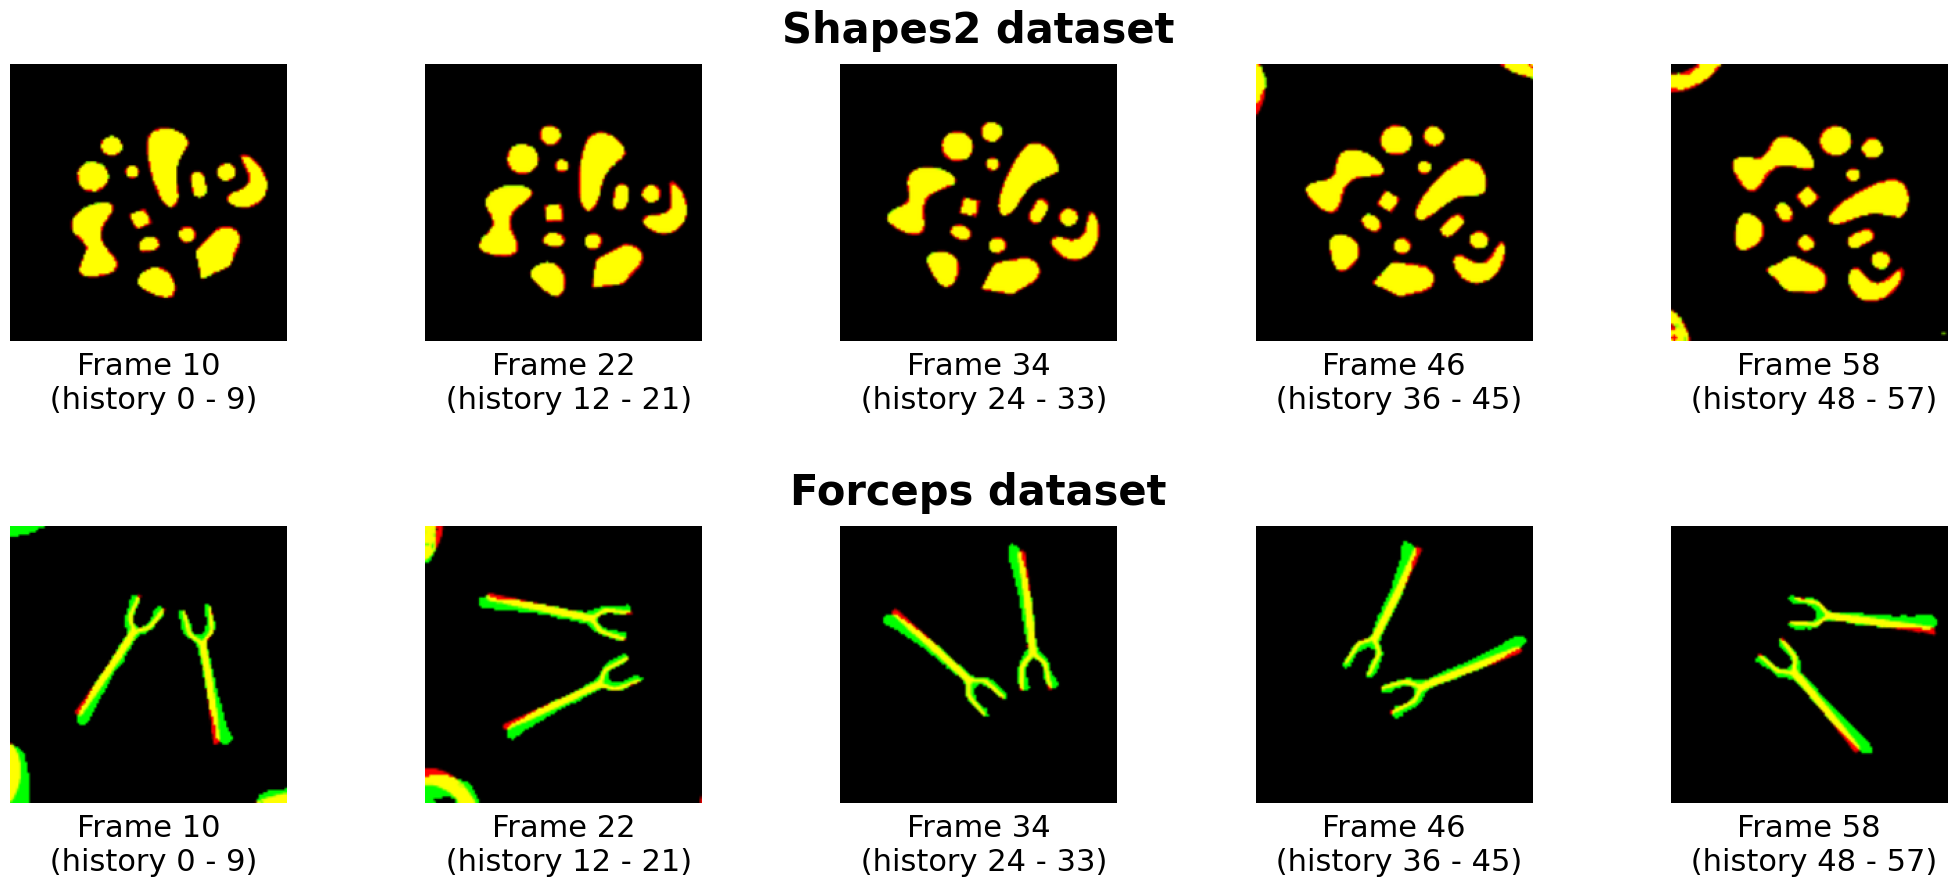

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_frames_side_by_side(frame_lists, rows, cols, cat_lists, frame_no):
    fig, axes = plt.subplots(len(frame_lists), cols, figsize=(cols * 5, len(frame_lists) * 5))
    # fig.suptitle("Row Titles", fontsize=18)  

    for r, frame_list in enumerate(frame_lists):
        for c in range(cols):
            ax = axes[r, c]
            if c < len(frame_list):
                frame = frame_list[c]
                ax.imshow(frame)
                ax.axis('off')
                fr_no = frame_no[c] + 10 
                text = f"Frame {fr_no}\n (history {fr_no - 10} - {fr_no - 1})"
                text_x = 0.5
                text_y = -0.15
                ax.text(text_x, text_y, text, ha='center', va='center', fontsize=22, transform=ax.transAxes)
                
        # Add a title above the center frame of each row
        row_title = cat_lists[r]
        col_center = cols // 2
        axes[r, col_center].set_title(row_title, fontsize=30,y=1.05,  fontweight='bold')


    plt.subplots_adjust(wspace=0.50, hspace=0.5)  # Adjust the spacing between subplots (increased here)
    plt.show()


rows = 2  # Number of rows in the grid
cols = len(img_lisk_2)  # Number of columns in the grid
plot_frames_side_by_side([img_lisk_2, img_lisk_1], rows, cols, ['Shapes2 dataset','Forceps dataset'], frame_no)

In [ ]:

def gif_to_frames (add):
    fname = add
    gif = imageio.mimread(fname)
    frames_target = [cv2.cvtColor(img1, cv2.COLOR_RGB2BGR) for img1 in gif]
    return frames_target

In [ ]:
tar = gif_to_frames('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/forceps_target_batch_1.gif')
op = gif_to_frames('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/forceps_output_batch_1.gif')


In [ ]:
tar_s = gif_to_frames('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/shapes2_target_batch_1.gif')
op_s = gif_to_frames('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/shapes2_output_batch_1.gif')


In [ ]:
for count,i in enumerate(tar_s):
    print(i.shape)
    plt.figure()
    plt.axis('off')
    plt.imshow(i,cmap ='gray')
    plt.tight_layout()
    plt.imsave(f'/home/drajani/Downloads/UNET/ConvLSTM/TESTING/metrics_shapes2/gt/gt_{count}.png',i)


In [ ]:
def calculate_tp_fp_fn_tn(pred, gt):
    tp = np.sum(np.logical_and(pred > 0, gt > 0))
    fp = np.sum(np.logical_and(pred > 0, gt == 0))
    fn = np.sum(np.logical_and(pred == 0, gt > 0))
    tn = np.sum(np.logical_and(pred == 0, gt == 0))
    return tp, fp, fn, tn



In [ ]:
DICTION = {'tp': [], 'fp': [], 'fn': [], 'tn': []}

for i in range(0,len(os.listdir('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/metrics_forceps/gt')),1):

        # Load predicted and ground truth images
        gt = cv2.imread('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/metrics_forceps/gt/' + f'gt_{i}.png', cv2.IMREAD_GRAYSCALE)
        pred = cv2.imread('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/metrics_forceps/output/' + f'op_{i}.png', cv2.IMREAD_GRAYSCALE)

        # Calculate TP, FP, FN, TN
        tp, fp, fn, tn = calculate_tp_fp_fn_tn(pred=pred, gt=gt)
        DICTION['tp'].append(tp)
        DICTION['fp'].append(fp)
        DICTION['fn'].append(fn)
        DICTION['tn'].append(tn)


In [ ]:
def calculate_mean(lst):
    if not lst:
        raise ValueError("The list is empty. Cannot calculate the mean.")
    
    total_sum = sum(lst)
    num_elements = len(lst)
    mean = total_sum / num_elements
    return mean


In [ ]:

print('tp: ',calculate_mean(DICTION['tp']))
print('fp: ',calculate_mean(DICTION['fp']))
print('fn: ',calculate_mean(DICTION['fn']))
print('tn: ',calculate_mean(DICTION['tn']))

tp:  642.0
fp:  271.7
fn:  148.68
tn:  15321.62


In [ ]:
from statistics import mean
print('tp: ',mean(DICTION['tp']))
print('fp: ',mean(DICTION['fp']))
print('fn: ',mean(DICTION['fn']))
print('tn: ',mean(DICTION['tn']))

In [ ]:
# forceps:
# Mean:  0.8970924556601745
# Minimum:  0.878727087441434
# Maximum:  0.908092672097284
# tp:  642
# fp:  271
# fn:  148
# tn:  15321


# shapes2:
# Mean:  0.8986284476983889
# Minimum:  0.8827487643227231
# Maximum:  0.9153520551810411
# tp:  2022
# fp:  1
# fn:  717
# tn:  13642

### ssim graph generation

Image similarity 0.9080479047472743
Image similarity 0.9031411017936787
Image similarity 0.8999233973158287
Image similarity 0.9047072529062514
Image similarity 0.9052315156353402
Image similarity 0.9011643221486791
Image similarity 0.9044833981657774
Image similarity 0.9019453595867226
Image similarity 0.905046031583814
Image similarity 0.8991189120882043
Image similarity 0.9049005919967207
Image similarity 0.9057506264552119
Image similarity 0.8999317499845289
Image similarity 0.904228606310215
Image similarity 0.9075873162166657
Image similarity 0.9052084989489381
Image similarity 0.9024649000173298
Image similarity 0.9014207718449315
Image similarity 0.9044876069110758
Image similarity 0.9024629286971511
Image similarity 0.9043401069479376
Image similarity 0.9021036830823215
Image similarity 0.902423910948973
Image similarity 0.9072583656894571
Image similarity 0.8966770597127337
Image similarity 0.9153520551810411
Image similarity 0.8948073640783388
Image similarity 0.910627636053

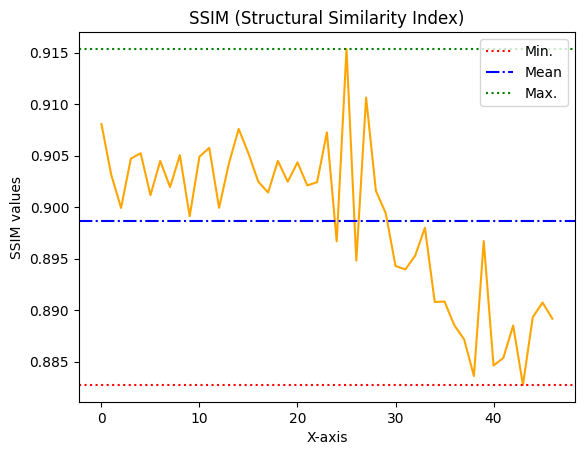

In [ ]:
from PIL import Image, ImageSequence
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean



from skimage.metrics import structural_similarity
import cv2



def calculate_ssim (pred,gt):
    # before =  cv2.imread(pred_path)
    # after = cv2.imread(gt_path)

    # First, we convert images to grayscale
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    gt =  cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)


    # Second, we find SSIM between 2 images
    (score, diff) = structural_similarity(pred, gt, full=True)
    print("Image similarity", score)

    # The diff image contains the actual image differences between the two images
    # and is represented as a floating point data type in the range [0,1]
    # so we must convert the array to 8-bit unsigned integers in the range
    # [0,255] before we can use it with OpenCV
    diff = (diff * 255).astype("uint8")

    # Threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    mask = np.zeros(pred.shape, dtype='uint8')
    filled_after = gt.copy()

    return score
def load_frames(image: Image, mode='RGB'):
    return np.array([
        np.array(frame.convert(mode))
        for frame in ImageSequence.Iterator(image)
    ])

def gif_to_numpy(gif_path):
  with Image.open(gif_path) as im:
      frames = load_frames(im)
  return frames[3:,:,:,:]



gif_gt_path = '/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/shapes2_output_batch_1.gif'
gif_pred_path = '/home/drajani/Downloads/UNET/ConvLSTM/TESTING/gifs_data_TESTING/gifs_40_epochs_shapes_training_centerloss/shapes2_target_batch_1.gif'

gt_frames = gif_to_numpy(gif_gt_path)
pred_frames = gif_to_numpy(gif_pred_path)


ssim_score = []
for i in range(gt_frames.shape[0]):
    ssim_score.append(calculate_ssim (pred=pred_frames[i], gt=gt_frames[i]))



print('Mean: ',mean(ssim_score))

print('Minimum: ',min(ssim_score))
print('Maximum: ',max(ssim_score))

# Generate x-values as indices of ssim_score list
x = range(len(ssim_score))

# Create a line plot
plt.plot(x, ssim_score,color='orange')

plt.axhline(y=min(ssim_score), color='red', linestyle='dotted', label='Min.')
plt.axhline(y=mean(ssim_score), color='blue', linestyle='dashdot',label ='Mean')
plt.axhline(y=max(ssim_score), color='green', linestyle='dotted',label ='Max.')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('SSIM values')
plt.title('SSIM (Structural Similarity Index)')

l = plt.legend(loc ='upper right')
  
# legend between blue and orange 
# line
l.set_zorder(2.5)


# ax1.set_xlabel('Frame Number', fontsize=14)
# ax1.set_ylabel('Category', fontsize=14)

In [ ]:
for i in lisk:
    print(i.shape)
    i = i.reshape(128,128,1)

    cv2.imwrite('/home/drajani/Downloads/UNET/ConvLSTM/TESTING/metrics_forceps/gt/gt.png',i)
    # plt.figure()
    # plt.imshow(i,cmap='gray')
    # # plt.imsave(f'/home/drajani/Downloads/UNET/ConvLSTM/TESTING/metrics_forceps/gt/gt_{i}.png)
    # plt.axis('off')
    # plt.tight_layout()
    # plt.savefig(f'/home/drajani/Downloads/UNET/ConvLSTM/TESTING/metrics_forceps/gt/gt.png')
    break








(128, 128)


In [ ]:
for i in range(0,len(lisk),1):
    lisk[i] = np.array(lisk[i].reshape(128,128).cpu())
lisk_arr = np.array(lisk)
lisk_arr = lisk_arr.reshape(1,lisk_arr.shape[0],lisk_arr.shape[1],lisk_arr.shape[2])

In [ ]:
for i in range(0,len(lisk_arr[0]),1):
    plt.figure()
    plt.imshow(lisk_arr[0][i],cmap ='gray')
    plt.imsave(f'/home/drajani/Downloads/UNET/ConvLSTM/TESTING/metrics_forceps/gt/lisk_{i}.png',lisk_arr[0][i],cmap='gray')

In [ ]:

for i in range(0,len(output[0]),1):
    plt.figure()
    plt.imshow(output[0][i],cmap ='gray')
    plt.imsave(f'/home/drajani/Downloads/UNET/METRICS_SHAPES_1_2/metrics_shapes_2/predicted_with_centerloss/op_{i}.png',output[0][i],cmap='gray')